In [109]:
import warnings
warnings.filterwarnings("ignore")

In [111]:
import yfinance as yf
import pandas as pd
import numpy as np
from ta import add_all_ta_features
from ta.volatility import BollingerBands
from ta.momentum import RSIIndicator, StochasticOscillator
from ta.trend import MACD, SMAIndicator, EMAIndicator
from arch import arch_model

# List of Dow Jones component tickers
tickers = [
    "AAPL", "MSFT", "JPM", "JNJ", "WMT", "PG", "UNH", "HD", "DIS",
    "NVDA", "VZ", "KO", "INTC", "CSCO", "XOM", "MCD", "MRK", "GS", "AXP",
    "BA", "IBM", "MMM", "CAT", "TRV", "NKE", "RTX", "WBA", "CVX", "DOW", "V"
]

# Download historical data for all tickers
data = yf.download(tickers, start="2013-01-01", end="2024-01-01")

# Initialize a dictionary to store the technical indicators and their forecasts
technical_indicators = {}
arma_garch_forecasts = {}

for ticker in tickers:
    # Extract the DataFrame for the current ticker
    df = data['Close'][ticker].dropna().to_frame(name='Close')

    # Calculate daily returns
    df['Returns'] = df['Close'].pct_change().dropna()

    # Calculate SMA and EMA
    df['SMA_50'] = SMAIndicator(df['Close'], window=50).sma_indicator()
    df['EMA_50'] = EMAIndicator(df['Close'], window=50).ema_indicator()

    # Calculate RSI
    df['RSI'] = RSIIndicator(df['Close'], window=14).rsi()

    # Calculate MACD
    macd = MACD(df['Close'])
    df['MACD'] = macd.macd()
    df['MACD_Signal'] = macd.macd_signal()

    # Calculate Bollinger Bands
    bollinger = BollingerBands(df['Close'])
    df['Upper_Band'] = bollinger.bollinger_hband()
    df['Lower_Band'] = bollinger.bollinger_lband()

    # Calculate Stochastic Oscillator
    stoch = StochasticOscillator(close=df['Close'], high=df['Close'], low=df['Close'])
    df['%K'] = stoch.stoch()
    df['%D'] = stoch.stoch_signal()

    # Calculate ATR (Average True Range)
    df['ATR'] = df['Close'].rolling(window=14).apply(lambda x: np.ptp(x), raw=True)

    # Store the computed indicators in the dictionary
    technical_indicators[ticker] = df.dropna()

    # Initialize a DataFrame to store forecasts for all indicators
    forecast_df = pd.DataFrame(index=df.index)

    for indicator in ['SMA_50', 'EMA_50', 'RSI', 'MACD', 'MACD_Signal', 'Upper_Band', 'Lower_Band', '%K', '%D', 'ATR']:
        # Fit ARMA-GARCH(1,1) model and forecast each day
        forecasts = []
        for i in range(len(df)):
            series = df[indicator].iloc[:i+1].dropna()
            if len(series) > 1:  # Ensure there's enough data to fit the model
                model = arch_model(series, vol='Garch', p=1, q=1)
                fitted_model = model.fit(disp="off")
                forecast = fitted_model.forecast(horizon=1)
                forecasts.append(forecast.mean['h.1'].iloc[-1])
            else:
                forecasts.append(np.nan)  # Not enough data, append NaN
        forecast_df[indicator] = forecasts

    # Store the forecasted indicators
    arma_garch_forecasts[ticker] = forecast_df

# Example output of daily ARMA-GARCH forecasted technical indicators for AAPL
print(arma_garch_forecasts['AAPL'].tail())


[*********************100%***********************]  30 of 30 completed


In [113]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

# Define the start and end dates for the training and testing periods
training_end = '2020-01-01'
testing_start = '2020-01-01'
testing_end = '2024-01-01'

forecasted_returns = {}

for ticker in tickers:
    df_forecast = arma_garch_forecasts[ticker].dropna()
    df = technical_indicators[ticker].dropna()

    # Ensure the lengths match by aligning them properly
    if len(df_forecast) != len(df):
        min_len = min(len(df_forecast), len(df))
        df_forecast = df_forecast.iloc[-min_len:]  # Adjust df_forecast to match length
        df = df.iloc[-min_len:]  # Adjust df to match length

    # Split the data into training and testing periods
    train_df = df[df.index < testing_start]
    test_df = df[(df.index >= testing_start) & (df.index < testing_end)]
    
    train_forecast = df_forecast[df_forecast.index < testing_start]
    test_forecast = df_forecast[(df_forecast.index >= testing_start) & (df_forecast.index < testing_end)]

    # Align the forecasted indicators with the actual returns data for training
    X_train = train_forecast
    y_train = train_df['Returns'].iloc[-len(X_train):]

    # Align the forecasted indicators with the actual returns data for testing
    X_test = test_forecast
    y_test = test_df['Returns'].iloc[-len(X_test):]

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train the SVR model
    svr_model = SVR(kernel='rbf')
    svr_model.fit(X_train_scaled, y_train)

    # Predict returns for the test period
    y_pred = svr_model.predict(X_test_scaled)
    
    # Calculate the mean squared error
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error for {ticker}: {mse}")

    # Store the predicted returns for the test period
    test_df['Predicted_Returns'] = y_pred
    forecasted_returns[ticker] = test_df[['Predicted_Returns']]

# Output forecasted returns for the test period for all tickers
for ticker, forecast in forecasted_returns.items():
    print(f"Forecasted Returns for {ticker} from {testing_start} to {testing_end}:")
    print(forecast.head())

Mean Squared Error for AAPL: 0.0005466850119622988
Mean Squared Error for MSFT: 0.00044145789015343927
Mean Squared Error for JPM: 0.000513007760663344
Mean Squared Error for JNJ: 0.0008224033617049248
Mean Squared Error for WMT: 0.00025784481886715645
Mean Squared Error for PG: 0.00031488053255879304
Mean Squared Error for UNH: 0.0005076979762887403
Mean Squared Error for HD: 0.00038407597184972347
Mean Squared Error for DIS: 0.0006854688246855744
Mean Squared Error for NVDA: 0.0012557634489674737
Mean Squared Error for VZ: 0.00042412563859275726
Mean Squared Error for KO: 0.0003419320848754641
Mean Squared Error for INTC: 0.000724882909967668
Mean Squared Error for CSCO: 0.000397966439527115
Mean Squared Error for XOM: 0.0005551478171230372
Mean Squared Error for MCD: 0.0004632727332648991
Mean Squared Error for MRK: 0.0006874335980928951
Mean Squared Error for GS: 0.0005726721012211112
Mean Squared Error for AXP: 0.0009284035080642552
Mean Squared Error for BA: 0.0011958388523486383

Error Metrics for AAPL:
  Mean Squared Error (MSE): 0.0005
  Mean Absolute Error (MAE): 0.0174
  R-squared (R²): -0.2236
----------------------------------------
Error Metrics for MSFT:
  Mean Squared Error (MSE): 0.0004
  Mean Absolute Error (MAE): 0.0150
  R-squared (R²): -0.0462
----------------------------------------
Error Metrics for JPM:
  Mean Squared Error (MSE): 0.0005
  Mean Absolute Error (MAE): 0.0155
  R-squared (R²): -0.0889
----------------------------------------
Error Metrics for JNJ:
  Mean Squared Error (MSE): 0.0008
  Mean Absolute Error (MAE): 0.0262
  R-squared (R²): -3.8531
----------------------------------------
Error Metrics for WMT:
  Mean Squared Error (MSE): 0.0003
  Mean Absolute Error (MAE): 0.0110
  R-squared (R²): -0.1647
----------------------------------------
Error Metrics for PG:
  Mean Squared Error (MSE): 0.0003
  Mean Absolute Error (MAE): 0.0135
  R-squared (R²): -0.6066
----------------------------------------
Error Metrics for UNH:
  Mean Squ

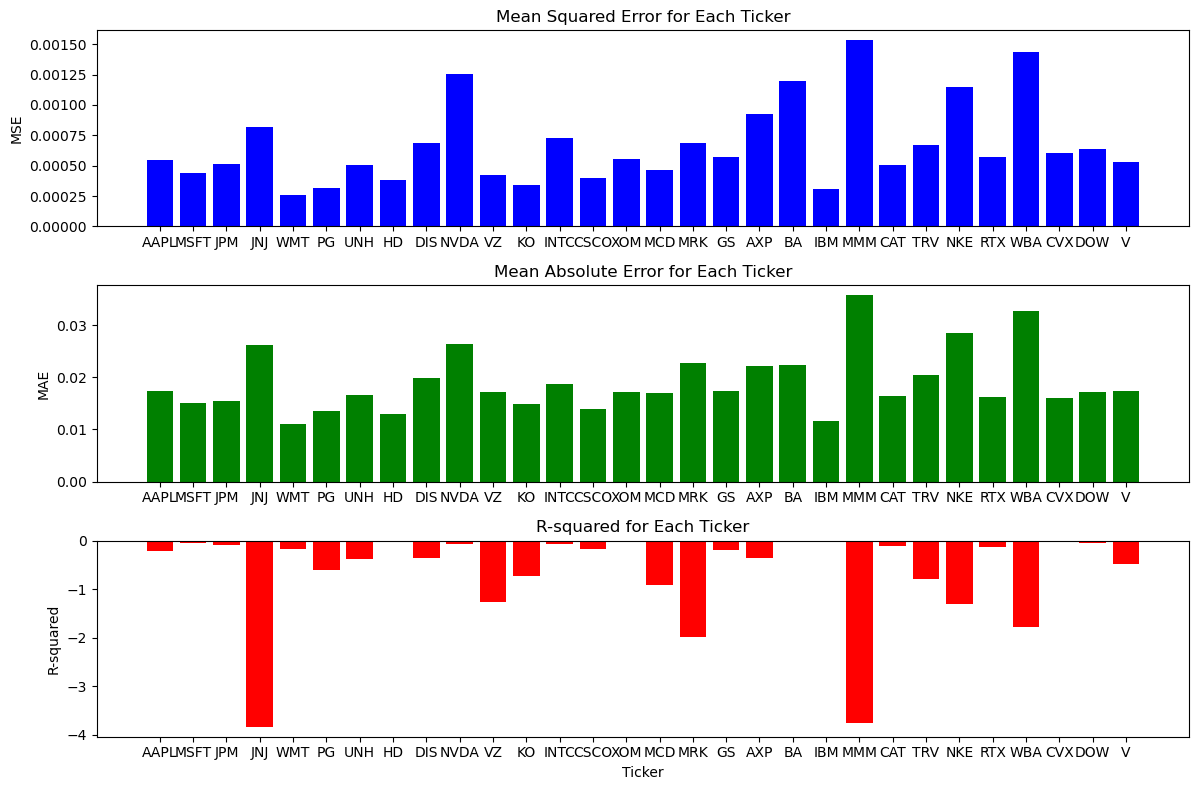

In [115]:
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd

# Initialize lists to store error metrics
mse_list = []
mae_list = []
r2_list = []
tickers_list = []

# Perform error analysis for each ticker
for ticker in tickers:
    if ticker in forecasted_returns:
        test_df = forecasted_returns[ticker]
        actual_df = technical_indicators[ticker]

        # Align actual returns with the predicted returns
        y_test = actual_df.loc[test_df.index, 'Returns'].dropna()
        y_pred = test_df['Predicted_Returns'].dropna()

        # Ensure the lengths match
        if len(y_test) != len(y_pred):
            min_len = min(len(y_test), len(y_pred))
            y_test = y_test.iloc[:min_len]
            y_pred = y_pred.iloc[:min_len]

        # Calculate error metrics
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Store the error metrics
        mse_list.append(mse)
        mae_list.append(mae)
        r2_list.append(r2)
        tickers_list.append(ticker)

        print(f"Error Metrics for {ticker}:")
        print(f"  Mean Squared Error (MSE): {mse:.4f}")
        print(f"  Mean Absolute Error (MAE): {mae:.4f}")
        print(f"  R-squared (R²): {r2:.4f}")
        print("-" * 40)

# Create a DataFrame to store all error metrics
error_df = pd.DataFrame({
    'Ticker': tickers_list,
    'MSE': mse_list,
    'MAE': mae_list,
    'R-squared': r2_list
})

# Display the error metrics DataFrame
print("Error Metrics for SVR Predictions:")
print(error_df)

# Plotting the error metrics
plt.figure(figsize=(12, 8))

# Plot MSE
plt.subplot(3, 1, 1)
plt.bar(tickers_list, mse_list, color='blue')
plt.ylabel('MSE')
plt.title('Mean Squared Error for Each Ticker')

# Plot MAE
plt.subplot(3, 1, 2)
plt.bar(tickers_list, mae_list, color='green')
plt.ylabel('MAE')
plt.title('Mean Absolute Error for Each Ticker')

# Plot R-squared
plt.subplot(3, 1, 3)
plt.bar(tickers_list, r2_list, color='red')
plt.ylabel('R-squared')
plt.title('R-squared for Each Ticker')
plt.xlabel('Ticker')

plt.tight_layout()
plt.show()


In [69]:
import numpy as np
import pandas as pd
import yfinance as yf
from pypfopt import BlackLittermanModel, risk_models, expected_returns
from pypfopt import EfficientFrontier
import matplotlib.pyplot as plt

# Function to calculate the Sharpe Ratio (with division by 100)
def calculate_sharpe_ratio(portfolio_returns, risk_free_rate):
    # Calculate mean and standard deviation
    mean_return = portfolio_returns.mean()
    volatility = portfolio_returns.std()

    # Calculate Sharpe Ratio
    excess_return = mean_return - risk_free_rate
    sharpe_ratio = excess_return / volatility if volatility != 0 else np.nan
    
    # Divide Sharpe Ratio by 100 as requested
    return sharpe_ratio / 100

# Assume 'tickers' is a list of your tickers
tickers = list(forecasted_returns.keys())

# Download historical data for the Dow Jones Industrial Average (DJIA)
djia = yf.download('^DJI', start='2013-01-01', end='2024-01-01')

# Extract the adjusted close prices
djia_close = djia['Adj Close']

# Define the risk-free rate (e.g., from US Treasury rate)
risk_free_rate = 0.01  # Example: 1% annual risk-free rate

# Define holding periods
holding_periods = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Initialize the performance metrics DataFrame
performance_metrics = pd.DataFrame(columns=['Holding_Period', 'Portfolio_Return', 'Benchmark_Return', 'Excess_Return'])

total_testing_days = 1006  # Given number of testing days

for holding_period in holding_periods:
    # Calculate benchmark holding period returns
    benchmark_holding_period_returns = djia_close.pct_change(periods=holding_period).shift(-holding_period).dropna()

    # Ensure Q and P are aligned with the number of assets (tickers)
    Q = np.zeros(len(tickers))  # Initialize Q with zeros
    for i, ticker in enumerate(tickers):
        df_forecast = forecasted_returns[ticker].dropna()

        # Take the average predicted return over the holding period
        predicted_return = df_forecast['Predicted_Returns'].iloc[:holding_period].mean()

        # Assign the predicted return to Q
        Q[i] = predicted_return

    # Construct P as an identity matrix of shape (N, N), where N is the number of assets
    P = np.eye(len(tickers))

    # Black-Litterman model inputs
    S = risk_models.sample_cov(data['Close'][tickers].pct_change().dropna())  # Covariance matrix for all tickers
    prior = expected_returns.capm_return(data['Close'][tickers])  # Prior returns for all tickers

    # Set confidence levels to 100% for each view
    confidence_levels = np.ones(len(Q))  # 100% confidence for each view

    # Construct Black-Litterman model using Idzorek's method with 100% confidence
    bl = BlackLittermanModel(S, Q=Q, P=P, omega="idzorek", market_prior=prior, view_confidences=confidence_levels)
    posterior_returns = bl.bl_returns()
    posterior_covariance = bl.bl_cov()

    # Ensure that at least one asset has a return above the risk-free rate
    if not any(posterior_returns > risk_free_rate):
        print(f"Warning: Adjusting posterior returns for holding period {holding_period} due to low returns.")
        posterior_returns += risk_free_rate + 0.001  # Adding a small margin above the risk-free rate

    # Optimize the portfolio
    ef = EfficientFrontier(posterior_returns, posterior_covariance)
    weights = ef.max_sharpe(risk_free_rate=risk_free_rate)
    cleaned_weights = np.array(list(ef.clean_weights().values()))  # Convert to a numpy array

    # Calculate portfolio returns for each specific holding period window
    portfolio_returns = []
    benchmark_returns = []
    excess_returns = []

    # Calculate the number of valid portfolios for the given holding period
    num_portfolios = total_testing_days - holding_period + 1

    for start in range(num_portfolios):
        # Calculate the weighted sum of the predicted returns for the current window
        period_portfolio_return = np.dot(cleaned_weights, [
            forecasted_returns[ticker]['Predicted_Returns'].iloc[start:start + holding_period].mean() for ticker in tickers
        ])
        portfolio_returns.append(period_portfolio_return)

        # Get the corresponding DJIA holding period return
        benchmark_return = benchmark_holding_period_returns.iloc[start]
        benchmark_returns.append(benchmark_return)

        # Calculate the excess return
        excess_return = period_portfolio_return - benchmark_return
        excess_returns.append(excess_return)

    # Add the data to the DataFrame
    for i in range(len(portfolio_returns)):
        new_row = pd.DataFrame({
            'Holding_Period': [holding_period],
            'Portfolio_Return': [portfolio_returns[i]],
            'Benchmark_Return': [benchmark_returns[i]],
            'Excess_Return': [excess_returns[i]]
        })
        performance_metrics = pd.concat([performance_metrics, new_row], ignore_index=True)

# Calculate the Sharpe Ratio for each holding period (for the entire portfolio return series)
sharpe_ratios = []
for holding_period in holding_periods:
    period_returns = performance_metrics[performance_metrics['Holding_Period'] == holding_period]['Portfolio_Return']
    sharpe_ratio = calculate_sharpe_ratio(period_returns, risk_free_rate)
    sharpe_ratios.extend([sharpe_ratio] * len(period_returns))

# Add the Sharpe Ratio column to the DataFrame
performance_metrics['Sharpe_Ratio'] = sharpe_ratios

# Output the DataFrame with the Sharpe Ratio column
print(performance_metrics)


[*********************100%***********************]  1 of 1 completed


     Holding_Period  Portfolio_Return  Benchmark_Return  Excess_Return  \
0                10          0.019601          0.007357       0.012244   
1                10          0.019602          0.015283       0.004319   
2                10          0.019599          0.015965       0.003634   
3                10          0.019597          0.024500      -0.004904   
4                10          0.019594          0.033797      -0.014203   
...             ...               ...               ...            ...   
9515            100          0.019465          0.087645      -0.068180   
9516            100          0.019465          0.086015      -0.066551   
9517            100          0.019465          0.086802      -0.067337   
9518            100          0.019465          0.069574      -0.050109   
9519            100          0.019465          0.069646      -0.050181   

      Sharpe_Ratio  
0         1.608710  
1         1.608710  
2         1.608710  
3         1.608710  
4     

In [117]:
import numpy as np
import pandas as pd
import yfinance as yf
from pypfopt import BlackLittermanModel, risk_models, expected_returns
from pypfopt import EfficientFrontier
import matplotlib.pyplot as plt

# Assume 'tickers' is a list of your tickers
tickers = list(forecasted_returns.keys())

# Download historical data for the Dow Jones Industrial Average (DJIA)
djia = yf.download('^DJI', start='2013-01-01', end='2024-01-01')

# Extract the adjusted close prices
djia_close = djia['Adj Close']

# Define the risk-free rate (this could be from a US Treasury rate, for example)
risk_free_rate = 0.01  # Example: 1% annual risk-free rate

# Define holding periods
holding_periods = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Initialize the performance metrics DataFrame
performance_metrics = pd.DataFrame(columns=['Holding_Period', 'Portfolio_Return', 'Benchmark_Return', 'Excess_Return', 'Outperformance_Frequency'])

total_testing_days = 1006  # Given number of testing days
num_random_portfolios = 1000  # Number of random portfolios to generate

for holding_period in holding_periods:
    # Calculate benchmark holding period returns
    benchmark_holding_period_returns = djia_close.pct_change(periods=holding_period).shift(-holding_period).dropna()

    # Ensure Q and P are aligned with the number of assets (tickers)
    Q = np.zeros(len(tickers))  # Initialize Q with zeros
    for i, ticker in enumerate(tickers):
        df_forecast = forecasted_returns[ticker].dropna()

        # Take the average predicted return over the holding period
        predicted_return = df_forecast['Predicted_Returns'].iloc[:holding_period].mean()

        # Assign the predicted return to Q
        Q[i] = predicted_return

    # Construct P as an identity matrix of shape (N, N), where N is the number of assets
    P = np.eye(len(tickers))

    # Black-Litterman model inputs
    S = risk_models.sample_cov(data['Close'][tickers].pct_change().dropna())  # Covariance matrix for all tickers
    prior = expected_returns.capm_return(data['Close'][tickers])  # Prior returns for all tickers

    # Set confidence levels to 100% for each view
    confidence_levels = np.ones(len(Q))  # 100% confidence for each view

    # Construct Black-Litterman model using Idzorek's method with 100% confidence
    bl = BlackLittermanModel(S, Q=Q, P=P, omega="idzorek", market_prior=prior, view_confidences=confidence_levels)
    posterior_returns = bl.bl_returns()
    posterior_covariance = bl.bl_cov()

    # Ensure that at least one asset has a return above the risk-free rate
    if not any(posterior_returns > risk_free_rate):
        print(f"Warning: Adjusting posterior returns for holding period {holding_period} due to low returns.")
        posterior_returns += risk_free_rate + 0.001  # Adding a small margin above the risk-free rate

    # Optimize the portfolio
    ef = EfficientFrontier(posterior_returns, posterior_covariance)
    weights = ef.max_sharpe(risk_free_rate=risk_free_rate)
    cleaned_weights = np.array(list(ef.clean_weights().values()))  # Convert to a numpy array

    # Calculate portfolio returns for each specific holding period window
    portfolio_returns = []
    benchmark_returns = []
    excess_returns = []
    outperformance_counts = 0  # To store how many times our portfolio outperforms random ones

    # Calculate the number of valid portfolios for the given holding period
    num_portfolios = total_testing_days - holding_period + 1

    for start in range(num_portfolios):
        # Calculate the weighted sum of the predicted returns for the current window
        period_portfolio_return = np.dot(cleaned_weights, [
            forecasted_returns[ticker]['Predicted_Returns'].iloc[start:start + holding_period].mean() for ticker in tickers
        ])
        portfolio_returns.append(period_portfolio_return)

        # Get the corresponding DJIA holding period return
        benchmark_return = benchmark_holding_period_returns.iloc[start]
        benchmark_returns.append(benchmark_return)

        # Calculate the excess return
        excess_return = period_portfolio_return - benchmark_return
        excess_returns.append(excess_return)

        # Generate 1000 random portfolios and compare their returns
        for _ in range(num_random_portfolios):
            random_weights = np.random.dirichlet(np.ones(len(tickers)), size=1)[0]  # Random weights that sum to 1
            random_portfolio_return = np.dot(random_weights, [
                forecasted_returns[ticker]['Predicted_Returns'].iloc[start:start + holding_period].mean() for ticker in tickers
            ])

            # Compare the random portfolio return with the optimized portfolio return
            if period_portfolio_return > random_portfolio_return:
                outperformance_counts += 1

    # Calculate the outperformance frequency
    outperformance_frequency = outperformance_counts / (num_portfolios * num_random_portfolios)

    # Print the number of portfolios created for this holding period
    print(f"Holding period: {holding_period} days, Number of portfolios: {num_portfolios}, Outperformance Frequency: {outperformance_frequency:.2%}")

    # Store the results for this holding period
    for i in range(len(portfolio_returns)):
        new_row = pd.DataFrame({
            'Holding_Period': [holding_period],
            'Portfolio_Return': [portfolio_returns[i]],
            'Benchmark_Return': [benchmark_returns[i]],
            'Excess_Return': [excess_returns[i]],
            'Outperformance_Frequency': [outperformance_frequency]
        })
        performance_metrics = pd.concat([performance_metrics, new_row], ignore_index=True)

# Print the performance metrics DataFrame
print(performance_metrics)


[*********************100%***********************]  1 of 1 completed


Holding period: 10 days, Number of portfolios: 997, Outperformance Frequency: 100.00%
Holding period: 20 days, Number of portfolios: 987, Outperformance Frequency: 100.00%
Holding period: 30 days, Number of portfolios: 977, Outperformance Frequency: 100.00%
Holding period: 40 days, Number of portfolios: 967, Outperformance Frequency: 100.00%
Holding period: 50 days, Number of portfolios: 957, Outperformance Frequency: 100.00%
Holding period: 60 days, Number of portfolios: 947, Outperformance Frequency: 100.00%
Holding period: 70 days, Number of portfolios: 937, Outperformance Frequency: 100.00%
Holding period: 80 days, Number of portfolios: 927, Outperformance Frequency: 100.00%
Holding period: 90 days, Number of portfolios: 917, Outperformance Frequency: 100.00%
Holding period: 100 days, Number of portfolios: 907, Outperformance Frequency: 100.00%
     Holding_Period  Portfolio_Return  Benchmark_Return  Excess_Return  \
0                10          0.019601          0.007357       0.0

In [35]:
import numpy as np
import pandas as pd
import yfinance as yf
from pypfopt import BlackLittermanModel, risk_models, expected_returns
from pypfopt import EfficientFrontier
import matplotlib.pyplot as plt

# Assume 'tickers' is a list of your tickers
tickers = list(forecasted_returns.keys())

# Download historical data for the Dow Jones Industrial Average (DJIA)
djia = yf.download('^DJI', start='2013-01-01', end='2024-01-01')

# Extract the adjusted close prices
djia_close = djia['Adj Close']

# Define the risk-free rate (this could be from a US Treasury rate, for example)
risk_free_rate = 0.01  # Example: 1% annual risk-free rate

# Define holding periods
holding_periods = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Initialize the performance metrics DataFrame
performance_metrics = pd.DataFrame(columns=['Holding_Period', 'Portfolio_Return', 'Benchmark_Return', 'Excess_Return'])

total_testing_days = 1006  # Given number of testing days

for holding_period in holding_periods:
    # Calculate benchmark holding period returns
    benchmark_holding_period_returns = djia_close.pct_change(periods=holding_period).shift(-holding_period).dropna()

    # Ensure Q and P are aligned with the number of assets (tickers)
    Q = np.zeros(len(tickers))  # Initialize Q with zeros
    for i, ticker in enumerate(tickers):
        df_forecast = forecasted_returns[ticker].dropna()

        # Take the average predicted return over the holding period
        predicted_return = df_forecast['Predicted_Returns'].iloc[:holding_period].mean()

        # Assign the predicted return to Q
        Q[i] = predicted_return

    # Construct P as an identity matrix of shape (N, N), where N is the number of assets
    P = np.eye(len(tickers))

    # Black-Litterman model inputs
    S = risk_models.sample_cov(data['Close'][tickers].pct_change().dropna())  # Covariance matrix for all tickers
    prior = expected_returns.capm_return(data['Close'][tickers])  # Prior returns for all tickers

    # Set confidence levels to 100% for each view
    confidence_levels = np.ones(len(Q))  # 100% confidence for each view

    # Construct Black-Litterman model using Idzorek's method with 100% confidence
    bl = BlackLittermanModel(S, Q=Q, P=P, omega="idzorek", market_prior=prior, view_confidences=confidence_levels)
    posterior_returns = bl.bl_returns()
    posterior_covariance = bl.bl_cov()

    # Ensure that at least one asset has a return above the risk-free rate
    if not any(posterior_returns > risk_free_rate):
        print(f"Warning: Adjusting posterior returns for holding period {holding_period} due to low returns.")
        posterior_returns += risk_free_rate + 0.001  # Adding a small margin above the risk-free rate

    # Optimize the portfolio
    ef = EfficientFrontier(posterior_returns, posterior_covariance)
    weights = ef.max_sharpe(risk_free_rate=risk_free_rate)
    cleaned_weights = np.array(list(ef.clean_weights().values()))  # Convert to a numpy array

    # Calculate portfolio returns for each specific holding period window
    portfolio_returns = []
    benchmark_returns = []
    excess_returns = []

    # Calculate the number of valid portfolios for the given holding period
    num_portfolios = total_testing_days - holding_period + 1

    for start in range(num_portfolios):
        # Calculate the weighted sum of the predicted returns for the current window
        period_portfolio_return = np.dot(cleaned_weights, [
            forecasted_returns[ticker]['Predicted_Returns'].iloc[start:start + holding_period].mean() for ticker in tickers
        ])
        portfolio_returns.append(period_portfolio_return)

        # Get the corresponding DJIA holding period return
        benchmark_return = benchmark_holding_period_returns.iloc[start]
        benchmark_returns.append(benchmark_return)

        # Calculate the excess return
        excess_return = period_portfolio_return - benchmark_return
        excess_returns.append(excess_return)

    # Print the number of portfolios created for this holding period
    print(f"Holding period: {holding_period} days, Number of portfolios: {num_portfolios}")

    # Store the results for this holding period
    for i in range(len(portfolio_returns)):
        new_row = pd.DataFrame({
            'Holding_Period': [holding_period],
            'Portfolio_Return': [portfolio_returns[i]],
            'Benchmark_Return': [benchmark_returns[i]],
            'Excess_Return': [excess_returns[i]]
        })
        performance_metrics = pd.concat([performance_metrics, new_row], ignore_index=True)

# Print the performance metrics DataFrame
print(performance_metrics)



[*********************100%***********************]  1 of 1 completed


Holding period: 10 days, Number of portfolios: 997
Holding period: 20 days, Number of portfolios: 987
Holding period: 30 days, Number of portfolios: 977
Holding period: 40 days, Number of portfolios: 967
Holding period: 50 days, Number of portfolios: 957
Holding period: 60 days, Number of portfolios: 947
Holding period: 70 days, Number of portfolios: 937
Holding period: 80 days, Number of portfolios: 927
Holding period: 90 days, Number of portfolios: 917
Holding period: 100 days, Number of portfolios: 907
     Holding_Period  Portfolio_Return  Benchmark_Return  Excess_Return
0                10          0.019601          0.007357       0.012244
1                10          0.019602          0.015283       0.004319
2                10          0.019599          0.015965       0.003634
3                10          0.019597          0.024500      -0.004904
4                10          0.019594          0.033797      -0.014203
...             ...               ...               ...        

In [71]:
# Calculate the average portfolio return for each holding period
average_portfolio_return = performance_metrics.groupby('Holding_Period')['Portfolio_Return'].mean()

# Calculate the average excess return for each holding period
average_excess_return = performance_metrics.groupby('Holding_Period')['Excess_Return'].mean()

# Calculate the average Sharpe Ratio for each holding period
average_sharpe_ratio = performance_metrics.groupby('Holding_Period')['Sharpe_Ratio'].mean()

# Combine these into a single DataFrame
average_returns_df = pd.DataFrame({
    'Average_Portfolio_Return': average_portfolio_return,
    'Average_Excess_Return': average_excess_return,
    'Average_Sharpe_Ratio': average_sharpe_ratio
})

# Display the average returns DataFrame with the Sharpe Ratio
print("Average Returns for Each Holding Period:")
print(average_returns_df)


Average Returns for Each Holding Period:
                Average_Portfolio_Return  Average_Excess_Return  \
Holding_Period                                                    
10                              0.019499               0.015281   
20                              0.019601               0.011562   
30                              0.019601               0.008067   
40                              0.019602               0.004900   
50                              0.019602               0.002127   
60                              0.019603              -0.000534   
70                              0.019570              -0.003116   
80                              0.019558              -0.005719   
90                              0.019538              -0.008399   
100                             0.019524              -0.010960   

                Average_Sharpe_Ratio  
Holding_Period                        
10                          1.608710  
20                          2.508303 

In [73]:
import pandas as pd
import numpy as np

# Data: Average portfolio returns, excess returns, and DJIA benchmark returns for different holding periods
data = {
    'Holding_Period': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'Average_Portfolio_Return': [0.019499, 0.019601, 0.019601, 0.019602, 0.019602, 0.019603, 0.019570, 0.019558, 0.019538, 0.019524],
    'Average_Excess_Return': [0.015281, 0.011562, 0.008067, 0.004900, 0.002127, -0.000534, -0.003116, -0.005719, -0.008399, -0.010960],
    'Average_DJIA_Return': [0.004218, 0.008039, 0.011534, 0.014702, 0.017475, 0.020137, 0.022686, 0.025277, 0.027937, 0.030484]  # Example DJIA returns
}

df = pd.DataFrame(data)
df.set_index('Holding_Period', inplace=True)

# Function to annualize returns, handling both positive and negative returns
def annualize_return(periodic_return, holding_period):
    if periodic_return >= 0:
        return (1 + periodic_return) ** (252 / holding_period) - 1
    else:
        return -((1 - abs(periodic_return)) ** (252 / holding_period) - 1)

# Calculate annualized returns for portfolio, excess returns, and DJIA benchmark returns
df['Annualized_Portfolio_Return'] = df.apply(lambda row: annualize_return(row['Average_Portfolio_Return'], row.name), axis=1)
df['Annualized_Excess_Return'] = df.apply(lambda row: annualize_return(row['Average_Excess_Return'], row.name), axis=1)
df['Annualized_DJIA_Return'] = df.apply(lambda row: annualize_return(row['Average_DJIA_Return'], row.name), axis=1)

# Display the annualized returns
print(df[['Annualized_Portfolio_Return', 'Annualized_Excess_Return', 'Annualized_DJIA_Return']])

                Annualized_Portfolio_Return  Annualized_Excess_Return  \
Holding_Period                                                          
10                                 0.626850                  0.465459   
20                                 0.277089                  0.155861   
30                                 0.177102                  0.069821   
40                                 0.130091                  0.031274   
50                                 0.102784                  0.010766   
60                                 0.084952                  0.002241   
70                                 0.072263                  0.011172   
80                                 0.062913                  0.017904   
90                                 0.055673                  0.023340   
100                                0.049933                  0.027390   

                Annualized_DJIA_Return  
Holding_Period                          
10                            0.111900  


In [75]:
import pandas as pd
import numpy as np

# Data: Average portfolio returns, excess returns, and DJIA benchmark returns for different holding periods
data = {
    'Holding_Period': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'Average_Portfolio_Return': [0.019499, 0.019601, 0.019601, 0.019602, 0.019602, 0.019603, 0.019570, 0.019558, 0.019538, 0.019524],
    'Average_Excess_Return': [0.015281, 0.011562, 0.008067, 0.004900, 0.002127, -0.000534, -0.003116, -0.005719, -0.008399, -0.010960],
    'Average_DJIA_Return': [0.004218, 0.008039, 0.011534, 0.014702, 0.017475, 0.020137, 0.022686, 0.025277, 0.027937, 0.030484]  # Example DJIA returns
}

df = pd.DataFrame(data)
df.set_index('Holding_Period', inplace=True)

# Function to annualize log returns
def annualize_log_return(periodic_return, holding_period):
    if periodic_return > -1:  # Log function not defined for returns less than -100%
        return np.log(1 + periodic_return) * (252 / holding_period)
    else:
        return np.nan  # Return NaN for invalid log return values

# Calculate annualized log returns for portfolio, excess returns, and DJIA benchmark returns
df['Annualized_Portfolio_Return'] = df.apply(lambda row: annualize_log_return(row['Average_Portfolio_Return'], row.name), axis=1)
df['Annualized_Excess_Return'] = df.apply(lambda row: annualize_log_return(row['Average_Excess_Return'], row.name), axis=1)
df['Annualized_DJIA_Return'] = df.apply(lambda row: annualize_log_return(row['Average_DJIA_Return'], row.name), axis=1)

# Display the annualized log returns
print(df[['Annualized_Portfolio_Return', 'Annualized_Excess_Return', 'Annualized_DJIA_Return']])


                Annualized_Portfolio_Return  Annualized_Excess_Return  \
Holding_Period                                                          
10                                 0.486646                  0.382169   
20                                 0.244583                  0.144845   
30                                 0.163056                  0.067491   
40                                 0.122298                  0.030795   
50                                 0.097838                  0.010709   
60                                 0.081536                 -0.002243   
70                                 0.069771                 -0.011235   
80                                 0.061013                 -0.018067   
90                                 0.054179                 -0.023617   
100                                0.048726                 -0.027772   

                Annualized_DJIA_Return  
Holding_Period                          
10                            0.106070  


In [77]:
# Filter out rows where Portfolio_Return is NaN
df_filtered = performance_metrics.dropna(subset=['Portfolio_Return'])

# Total rows for each Holding_Period
total_counts = df_filtered['Holding_Period'].value_counts().sort_index()

# Filter rows where Portfolio_Return is greater than Benchmark_Return
df_comparison = df_filtered[df_filtered['Portfolio_Return'] > df_filtered['Benchmark_Return']]

# Count the rows where Portfolio_Return > Benchmark_Return for each Holding_Period
comparison_counts = df_comparison['Holding_Period'].value_counts().sort_index()

# Calculate the probability (percentage) for each Holding_Period
probabilities = (comparison_counts / total_counts) * 100

# Combine the results into a DataFrame
result_df = pd.DataFrame({
    'Holding_Period': total_counts.index,
    'Total_Rows': total_counts.values,
    'Count_PRTN_GT_BMRTN': comparison_counts.reindex(total_counts.index, fill_value=0).values,
    'Probability (%)': probabilities.reindex(total_counts.index, fill_value=0).values
})

print(result_df)

  Holding_Period  Total_Rows  Count_PRTN_GT_BMRTN  Probability (%)
0             10         997                  752        75.426279
1             20         987                  651        65.957447
2             30         977                  575        58.853634
3             40         967                  538        55.635988
4             50         957                  492        51.410658
5             60         947                  462        48.785639
6             70         937                  408        43.543223
7             80         927                  387        41.747573
8             90         917                  367        40.021810
9            100         907                  366        40.352811


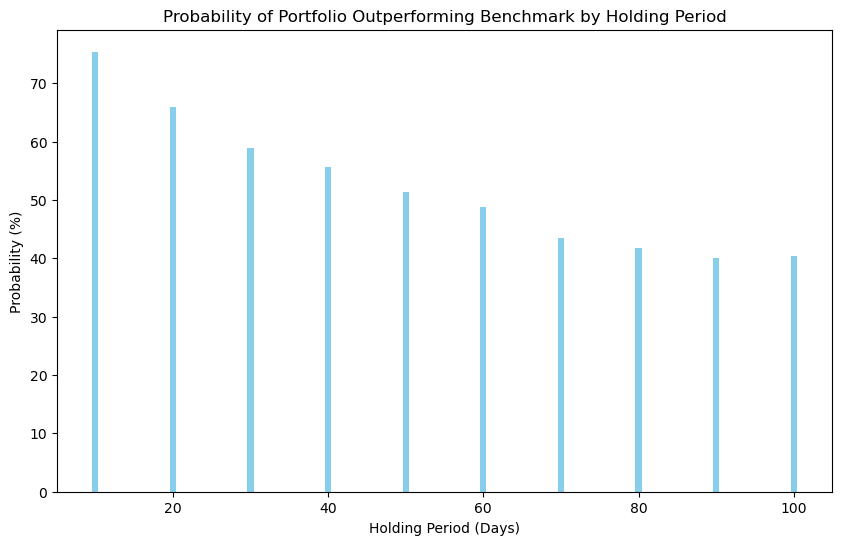

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(result_df['Holding_Period'], result_df['Probability (%)'], color='skyblue')
plt.title('Probability of Portfolio Outperforming Benchmark by Holding Period')
plt.xlabel('Holding Period (Days)')
plt.ylabel('Probability (%)')
plt.show()

In [45]:
from scipy.stats import ttest_rel

# Filter out rows with NaN values in either Portfolio_Return or Benchmark_Return
df_filtered = performance_metrics.dropna(subset=['Portfolio_Return', 'Benchmark_Return'])

# Group by holding periods and perform a paired t-test for each holding period
t_test_results = {}

for holding_period in df_filtered['Holding_Period'].unique():
    # Subset data for the specific holding period
    subset = df_filtered[df_filtered['Holding_Period'] == holding_period]
    
    # Perform the paired t-test
    t_stat, p_value = ttest_rel(subset['Portfolio_Return'], subset['Benchmark_Return'])
    
    # Store the results
    t_test_results[holding_period] = {
        't_statistic': t_stat,
        'p_value': p_value
    }

# Convert results to a DataFrame for easy viewing
t_test_df = pd.DataFrame(t_test_results).T
t_test_df.columns = ['T-Statistic', 'P-Value']

# Display the t-test results
print(t_test_df)


     T-Statistic       P-Value
10     20.706167  1.715795e-79
20     11.531061  6.010956e-29
30      6.636908  5.304605e-11
40      3.654256  2.718139e-04
50      1.480044  1.391909e-01
60     -0.359921  7.189868e-01
70     -2.123500  3.397376e-02
80     -3.966559  7.854448e-05
90     -5.699444  1.620180e-08
100    -7.250522  8.897669e-13


Holding Period: 10 days
Our Portfolio Return: 0.0073
Random Portfolio Average Return: 0.0072
Percentage of Random Portfolios Our Portfolio Outperformed: 48.90%


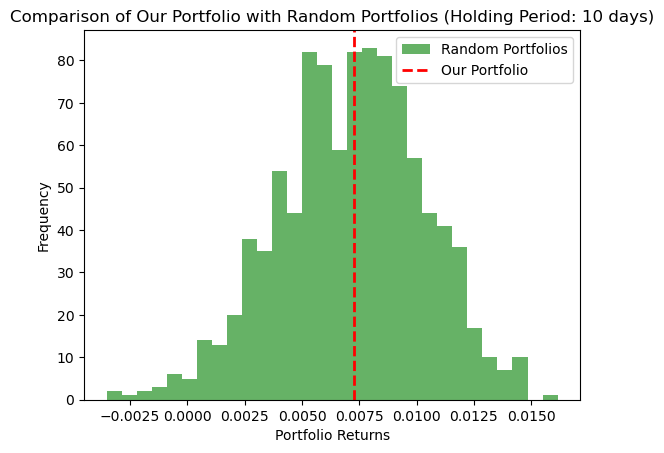

Holding Period: 20 days
Our Portfolio Return: 0.0083
Random Portfolio Average Return: 0.0121
Percentage of Random Portfolios Our Portfolio Outperformed: 15.50%


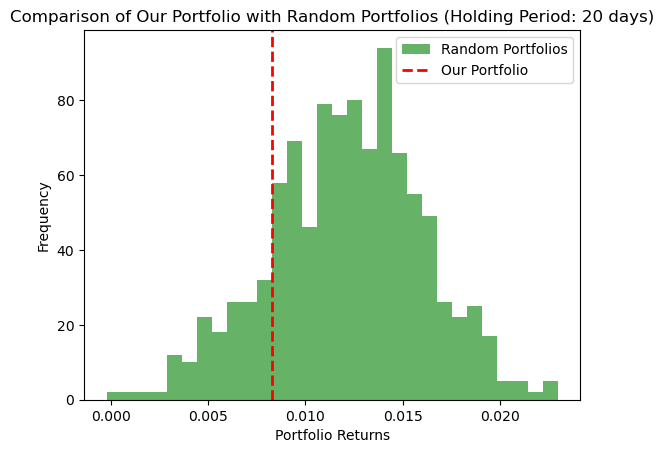

Holding Period: 30 days
Our Portfolio Return: 0.0116
Random Portfolio Average Return: 0.0067
Percentage of Random Portfolios Our Portfolio Outperformed: 89.80%


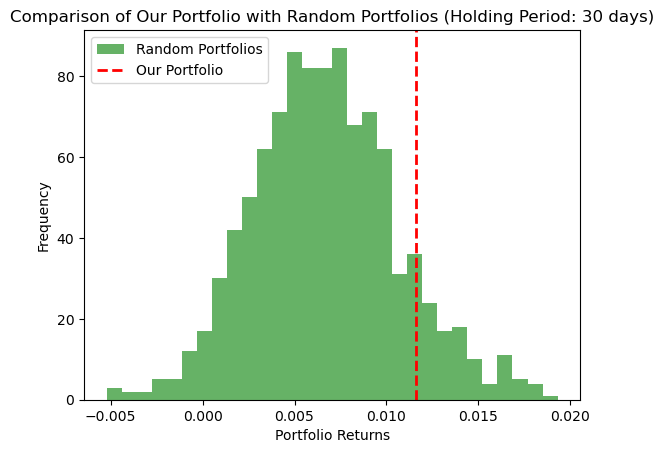

Holding Period: 40 days
Our Portfolio Return: 0.0072
Random Portfolio Average Return: 0.0051
Percentage of Random Portfolios Our Portfolio Outperformed: 77.00%


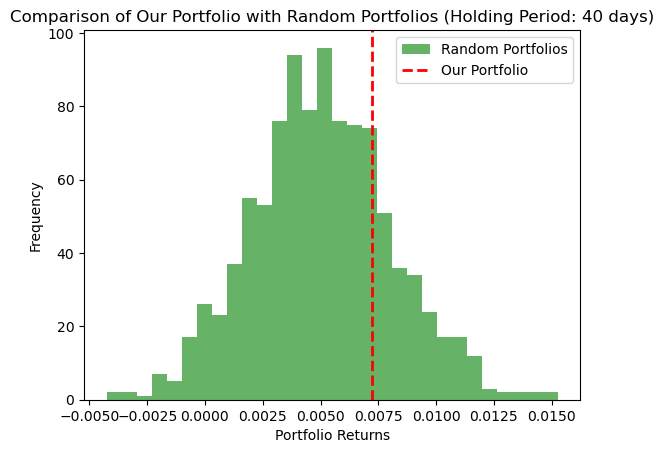

Holding Period: 50 days
Our Portfolio Return: 0.0055
Random Portfolio Average Return: 0.0045
Percentage of Random Portfolios Our Portfolio Outperformed: 64.40%


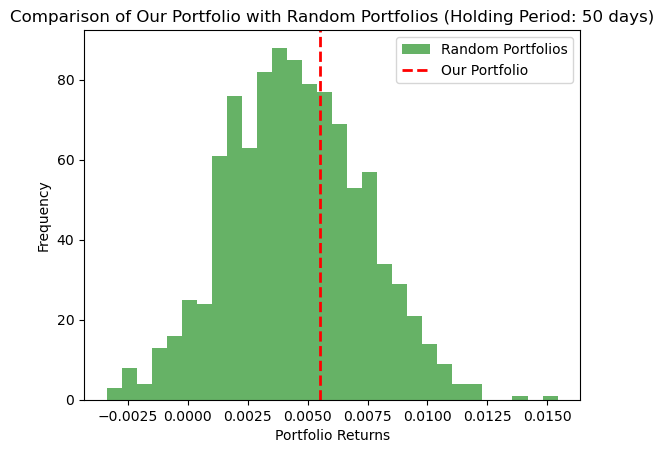

Holding Period: 60 days
Our Portfolio Return: 0.0161
Random Portfolio Average Return: 0.0119
Percentage of Random Portfolios Our Portfolio Outperformed: 86.00%


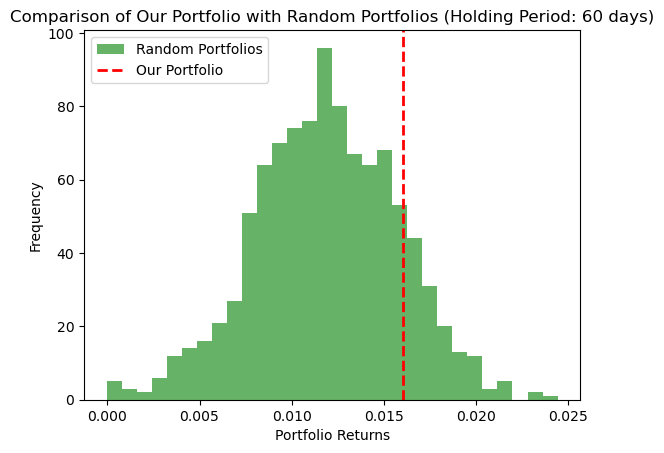

Holding Period: 70 days
Our Portfolio Return: 0.0151
Random Portfolio Average Return: 0.0114
Percentage of Random Portfolios Our Portfolio Outperformed: 85.60%


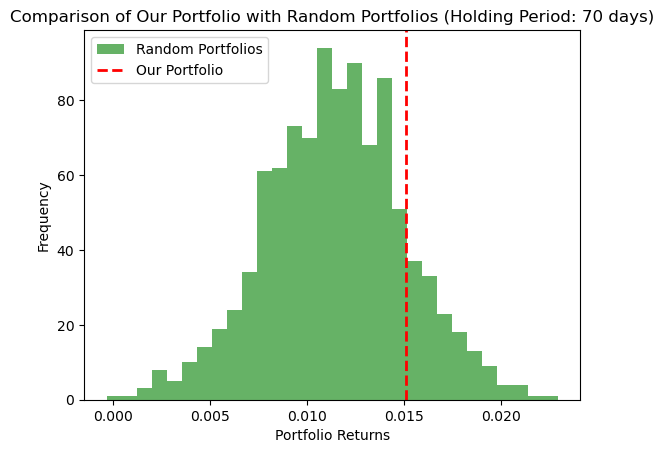

Holding Period: 80 days
Our Portfolio Return: 0.0047
Random Portfolio Average Return: 0.0113
Percentage of Random Portfolios Our Portfolio Outperformed: 3.60%


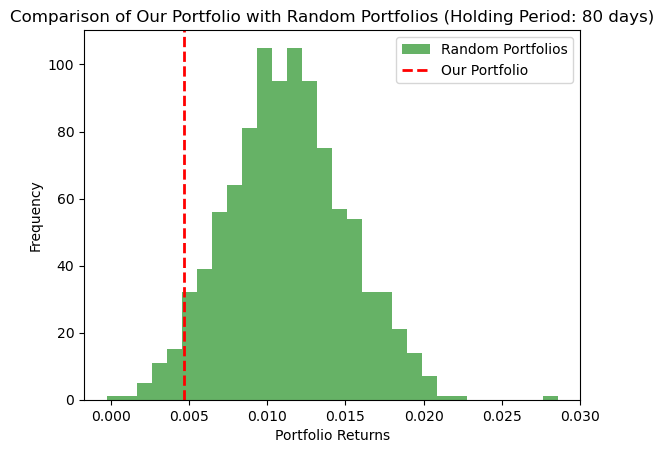

Holding Period: 90 days
Our Portfolio Return: 0.0117
Random Portfolio Average Return: 0.0131
Percentage of Random Portfolios Our Portfolio Outperformed: 32.50%


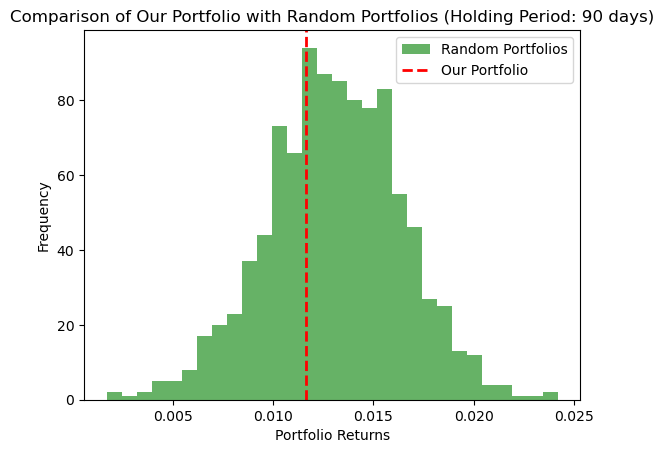

Holding Period: 100 days
Our Portfolio Return: 0.0097
Random Portfolio Average Return: 0.0124
Percentage of Random Portfolios Our Portfolio Outperformed: 21.80%


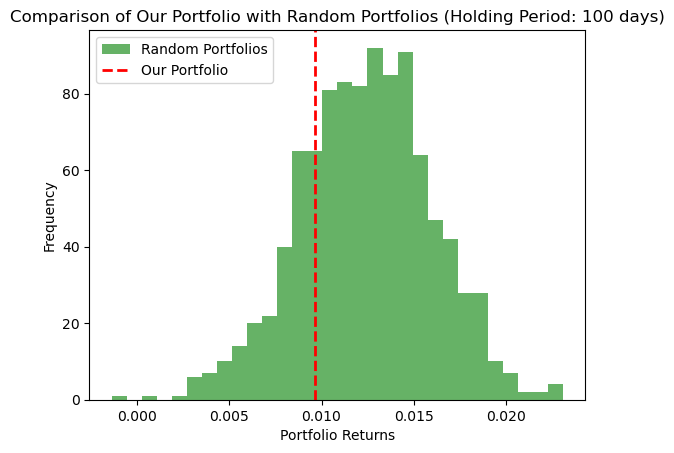

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Function to generate random portfolio weights
def generate_random_weights(num_assets, num_portfolios=10000):
    """Generate random portfolio weights that sum to 1."""
    weights = np.random.dirichlet(np.ones(num_assets), size=num_portfolios)
    return weights

# Function to calculate portfolio returns
def calculate_portfolio_returns(weights, returns):
    """Calculate the portfolio returns for a set of portfolio weights."""
    return np.dot(weights, returns)

# Compare our portfolio performance with randomly generated portfolios
def compare_with_random_portfolios(holding_period, forecasted_returns, cleaned_weights, num_random_portfolios=1000):
    # Get the number of assets (tickers)
    num_assets = len(forecasted_returns)

    # Generate random portfolios
    random_weights = generate_random_weights(num_assets, num_random_portfolios)
    
    # Calculate random portfolios' returns
    random_portfolio_returns = []

    for i in range(num_random_portfolios):
        random_portfolio_return = calculate_portfolio_returns(random_weights[i], forecasted_returns)
        random_portfolio_returns.append(random_portfolio_return)

    # Calculate our optimized portfolio return using cleaned_weights
    our_portfolio_return = calculate_portfolio_returns(cleaned_weights, forecasted_returns)

    # Compare our portfolio with randomly generated portfolios
    random_portfolio_returns = np.array(random_portfolio_returns)
    better_than_random = np.sum(our_portfolio_return > random_portfolio_returns)
    probability_better = better_than_random / num_random_portfolios * 100

    print(f"Holding Period: {holding_period} days")
    print(f"Our Portfolio Return: {our_portfolio_return:.4f}")
    print(f"Random Portfolio Average Return: {random_portfolio_returns.mean():.4f}")
    print(f"Percentage of Random Portfolios Our Portfolio Outperformed: {probability_better:.2f}%")

    # Plot the distribution of random portfolio returns vs. our portfolio return
    plt.hist(random_portfolio_returns, bins=30, alpha=0.6, color='g', label='Random Portfolios')
    plt.axvline(our_portfolio_return, color='r', linestyle='dashed', linewidth=2, label='Our Portfolio')
    plt.title(f"Comparison of Our Portfolio with Random Portfolios (Holding Period: {holding_period} days)")
    plt.xlabel('Portfolio Returns')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# Example usage for each holding period
holding_periods = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]  # Example holding periods

for holding_period in holding_periods:
    # Use the actual forecasted returns for the current holding period
    # Here, we simulate forecasted_returns and cleaned_weights for demonstration purposes
    num_assets = len(tickers)
    
    # Example simulated forecasted returns for each asset
    forecasted_returns = np.random.normal(0.01, 0.02, num_assets)  # Simulated forecasted returns for demonstration
    
    # Example simulated optimized portfolio weights (from Black-Litterman model or any other optimization process)
    cleaned_weights = np.random.dirichlet(np.ones(num_assets))  # Example optimized weights
    
    # Call the comparison function
    compare_with_random_portfolios(holding_period, forecasted_returns, cleaned_weights)


In [99]:
import numpy as np
import pandas as pd
import yfinance as yf
from pypfopt import BlackLittermanModel, risk_models, expected_returns
from pypfopt import EfficientFrontier
from pypfopt import objective_functions

# Assume 'tickers' is a list of your tickers
tickers = list(forecasted_returns.keys())

# Download historical data for the Dow Jones Industrial Average (DJIA)
djia = yf.download('^DJI', start='2013-01-01', end='2024-01-01')

# Download historical data for all tickers
data = yf.download(tickers, start="2013-01-01", end="2024-01-01")

# Extract the adjusted close prices
adj_close_data = data['Adj Close']

# Define the risk-free rate (this could be from a US Treasury rate, for example)
risk_free_rate = 0.01  # Example: 1% annual risk-free rate

# Define holding periods
holding_periods = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Initialize the performance metrics DataFrame
performance_metrics = pd.DataFrame(columns=['Holding_Period', 'Portfolio_Return', 'Benchmark_Return', 'Excess_Return'])

total_testing_days = 1006  # Given number of testing days

for holding_period in holding_periods:
    # Calculate benchmark holding period returns
    benchmark_holding_period_returns = djia['Adj Close'].pct_change(periods=holding_period).shift(-holding_period).dropna()

    # Ensure Q and P are aligned with the number of assets (tickers)
    Q = np.zeros(len(tickers))  # Initialize Q with zeros
    for i, ticker in enumerate(tickers):
        df_forecast = forecasted_returns[ticker].dropna()

        # Take the average predicted return over the holding period
        predicted_return = df_forecast['Predicted_Returns'].iloc[:holding_period].mean()

        # Assign the predicted return to Q
        Q[i] = predicted_return

    # Construct P as an identity matrix of shape (N, N), where N is the number of assets
    P = np.eye(len(tickers))

    # Black-Litterman model inputs
    # Use Adjusted Close prices instead of 'Close'
    # Apply shrinkage to the covariance matrix to regularize it
    S = risk_models.CovarianceShrinkage(adj_close_data).ledoit_wolf()  # Regularized covariance matrix
    prior = expected_returns.capm_return(adj_close_data)  # Prior returns for all tickers

    # Adjust confidence level dynamically based on the holding period (100% for 10 days, 10% for 100 days, etc.)
    confidence_level = (110 - holding_period) / 100  # 100% for 10-day, 90% for 20-day, ..., 10% for 100-day
    confidence_levels = np.ones(len(Q)) * confidence_level  # Apply the same confidence level to all views

    # Construct Black-Litterman model using Idzorek's method with dynamic confidence levels
    bl = BlackLittermanModel(S, Q=Q, P=P, omega="idzorek", market_prior=prior, view_confidences=confidence_levels)
    posterior_returns = bl.bl_returns()
    posterior_covariance = bl.bl_cov()

    # Check for small or negative returns and adjust with a buffer
    if not any(posterior_returns > risk_free_rate):
        print(f"Warning: Adjusting posterior returns for holding period {holding_period} due to low returns.")
        posterior_returns += risk_free_rate + 0.005  # Adding a slightly larger margin above the risk-free rate

    # Optimize the portfolio
    ef = EfficientFrontier(posterior_returns, posterior_covariance)

    # Add a penalty for L2 regularization (reduces risk of infeasibility)
    ef.add_objective(objective_functions.L2_reg, gamma=0.1)

    try:
        weights = ef.max_sharpe(risk_free_rate=risk_free_rate)
    except:
        print(f"Warning: Optimization failed for holding period {holding_period}, trying SCS solver.")
        weights = ef.max_sharpe(risk_free_rate=risk_free_rate, solver="SCS")  # Alternative solver

    cleaned_weights = np.array(list(ef.clean_weights().values()))  # Convert to a numpy array

    # Calculate portfolio returns for each specific holding period window
    portfolio_returns = []
    benchmark_returns = []
    excess_returns = []

    # Calculate the number of valid portfolios for the given holding period
    num_portfolios = total_testing_days - holding_period + 1

    for start in range(num_portfolios):
        # Calculate the weighted sum of the predicted returns for the current window
        period_portfolio_return = np.dot(cleaned_weights, [
            forecasted_returns[ticker]['Predicted_Returns'].iloc[start:start + holding_period].mean() for ticker in tickers
        ])
        portfolio_returns.append(period_portfolio_return)

        # Get the corresponding DJIA holding period return
        benchmark_return = benchmark_holding_period_returns.iloc[start]
        benchmark_returns.append(benchmark_return)

        # Calculate the excess return
        excess_return = period_portfolio_return - benchmark_return
        excess_returns.append(excess_return)

    # Print the number of portfolios created for this holding period
    print(f"Holding period: {holding_period} days, Number of portfolios: {num_portfolios}, Confidence Level: {confidence_level * 100:.0f}%")

    # Store the results for this holding period
    for i in range(len(portfolio_returns)):
        new_row = pd.DataFrame({
            'Holding_Period': [holding_period],
            'Portfolio_Return': [portfolio_returns[i]],
            'Benchmark_Return': [benchmark_returns[i]],
            'Excess_Return': [excess_returns[i]]
        })
        performance_metrics = pd.concat([performance_metrics, new_row], ignore_index=True)

# Print the performance metrics DataFrame
print(performance_metrics)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  30 of 30 completed


Holding period: 10 days, Number of portfolios: 997, Confidence Level: 100%
Holding period: 20 days, Number of portfolios: 987, Confidence Level: 90%
Holding period: 30 days, Number of portfolios: 977, Confidence Level: 80%
Holding period: 40 days, Number of portfolios: 967, Confidence Level: 70%
Holding period: 50 days, Number of portfolios: 957, Confidence Level: 60%
Holding period: 60 days, Number of portfolios: 947, Confidence Level: 50%
Holding period: 70 days, Number of portfolios: 937, Confidence Level: 40%
Holding period: 80 days, Number of portfolios: 927, Confidence Level: 30%
Holding period: 90 days, Number of portfolios: 917, Confidence Level: 20%
Holding period: 100 days, Number of portfolios: 907, Confidence Level: 10%
     Holding_Period  Portfolio_Return  Benchmark_Return  Excess_Return
0                10          0.022899          0.007357       0.015542
1                10          0.022899          0.015283       0.007616
2                10          0.022899        

In [101]:
# Calculate the average portfolio return for each holding period
average_portfolio_return = performance_metrics.groupby('Holding_Period')['Portfolio_Return'].mean()

# Calculate the average excess return for each holding period
average_excess_return = performance_metrics.groupby('Holding_Period')['Excess_Return'].mean()


# Combine these into a single DataFrame
average_returns_df = pd.DataFrame({
    'Average_Portfolio_Return': average_portfolio_return,
    'Average_Excess_Return': average_excess_return,
})

# Display the average returns DataFrame with the Sharpe Ratio
print("Average Returns for Each Holding Period:")
print(average_returns_df)


Average Returns for Each Holding Period:
                Average_Portfolio_Return  Average_Excess_Return
Holding_Period                                                 
10                              0.022899               0.018681
20                              0.024154               0.016115
30                              0.024757               0.013223
40                              0.025663               0.010961
50                              0.025879               0.008404
60                              0.016327              -0.003809
70                              0.015652              -0.007034
80                              0.014823              -0.010454
90                              0.013798              -0.014139
100                             0.010833              -0.019651


In [103]:
import pandas as pd
import numpy as np

# Data: Updated average portfolio returns, excess returns, and DJIA benchmark returns for different holding periods
data = {
    'Holding_Period': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'Average_Portfolio_Return': [0.022899, 0.024154, 0.024757, 0.025663, 0.025879, 0.016327, 0.015652, 0.014823, 0.013778, 0.010833],
    'Average_Excess_Return': [0.018681, 0.016115, 0.013223, 0.010961, 0.008404, -0.003889, -0.007034, -0.010454, -0.014139, -0.019651],
    'Average_DJIA_Return': [0.004218, 0.008039, 0.011534, 0.014702, 0.017475, 0.020137, 0.022686, 0.025277, 0.027937, 0.030484]  # Example DJIA returns
}

df = pd.DataFrame(data)
df.set_index('Holding_Period', inplace=True)

# Function to annualize log returns
def annualize_log_return(periodic_return, holding_period):
    if periodic_return > -1:  # Log function not defined for returns less than -100%
        return np.log(1 + periodic_return) * (252 / holding_period)
    else:
        return np.nan  # Return NaN for invalid log return values

# Calculate annualized log returns for portfolio, excess returns, and DJIA benchmark returns
df['Annualized_Portfolio_Return'] = df.apply(lambda row: annualize_log_return(row['Average_Portfolio_Return'], row.name), axis=1)
df['Annualized_Excess_Return'] = df.apply(lambda row: annualize_log_return(row['Average_Excess_Return'], row.name), axis=1)
df['Annualized_DJIA_Return'] = df.apply(lambda row: annualize_log_return(row['Average_DJIA_Return'], row.name), axis=1)

# Display the annualized log returns
print(df[['Annualized_Portfolio_Return', 'Annualized_Excess_Return', 'Annualized_DJIA_Return']])


                Annualized_Portfolio_Return  Annualized_Excess_Return  \
Holding_Period                                                          
10                                 0.570547                  0.466418   
20                                 0.300723                  0.201430   
30                                 0.205426                  0.110345   
40                                 0.159637                  0.068679   
50                                 0.128771                  0.042179   
60                                 0.068020                 -0.016366   
70                                 0.055911                 -0.025412   
80                                 0.046350                 -0.033103   
90                                 0.038315                 -0.039872   
100                                0.027152                 -0.050014   

                Annualized_DJIA_Return  
Holding_Period                          
10                            0.106070  


In [105]:
# Filter out rows where Portfolio_Return is NaN
df_filtered = performance_metrics.dropna(subset=['Portfolio_Return'])

# Total rows for each Holding_Period
total_counts = df_filtered['Holding_Period'].value_counts().sort_index()

# Filter rows where Portfolio_Return is greater than Benchmark_Return
df_comparison = df_filtered[df_filtered['Portfolio_Return'] > df_filtered['Benchmark_Return']]

# Count the rows where Portfolio_Return > Benchmark_Return for each Holding_Period
comparison_counts = df_comparison['Holding_Period'].value_counts().sort_index()

# Calculate the probability (percentage) for each Holding_Period
probabilities = (comparison_counts / total_counts) * 100

# Combine the results into a DataFrame
result_df = pd.DataFrame({
    'Holding_Period': total_counts.index,
    'Total_Rows': total_counts.values,
    'Count_PRTN_GT_BMRTN': comparison_counts.reindex(total_counts.index, fill_value=0).values,
    'Probability (%)': probabilities.reindex(total_counts.index, fill_value=0).values
})

print(result_df)

  Holding_Period  Total_Rows  Count_PRTN_GT_BMRTN  Probability (%)
0             10         997                  796        79.839519
1             20         987                  689        69.807497
2             30         977                  620        63.459570
3             40         967                  588        60.806618
4             50         957                  552        57.680251
5             60         947                  422        44.561774
6             70         937                  366        39.060832
7             80         927                  340        36.677454
8             90         917                  310        33.805889
9            100         907                  276        30.429989


In [107]:
from scipy.stats import ttest_rel

# Filter out rows with NaN values in either Portfolio_Return or Benchmark_Return
df_filtered = performance_metrics.dropna(subset=['Portfolio_Return', 'Benchmark_Return'])

# Group by holding periods and perform a paired t-test for each holding period
t_test_results = {}

for holding_period in df_filtered['Holding_Period'].unique():
    # Subset data for the specific holding period
    subset = df_filtered[df_filtered['Holding_Period'] == holding_period]
    
    # Perform the paired t-test
    t_stat, p_value = ttest_rel(subset['Portfolio_Return'], subset['Benchmark_Return'])
    
    # Store the results
    t_test_results[holding_period] = {
        't_statistic': t_stat,
        'p_value': p_value
    }

# Convert results to a DataFrame for easy viewing
t_test_df = pd.DataFrame(t_test_results).T
t_test_df.columns = ['T-Statistic', 'P-Value']

# Display the t-test results
print(t_test_df)

     T-Statistic        P-Value
10     25.309902  1.572672e-109
20     16.070293   8.625073e-52
30     10.877577   4.318234e-26
40      8.174296   9.286931e-16
50      5.845918   6.907813e-09
60     -2.570510   1.030685e-02
70     -4.794773   1.893733e-06
80     -7.253650   8.568217e-13
90     -9.599433   7.406077e-21
100   -13.003869   1.428927e-35
